Jairo Saul Diaz Soto

Dr. Thomas Pierre Robert Batard

Vision Computacional I

# Ejercicio 1: Amplitud vs Fase

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import copy
from scipy.signal.windows import gaussian
from scipy.signal import convolve

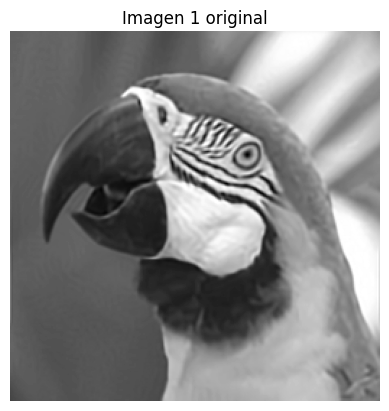

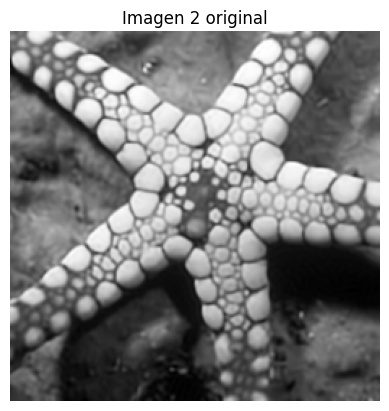

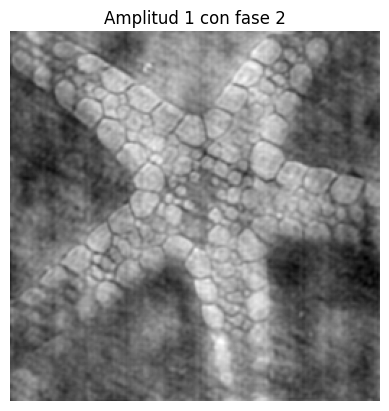

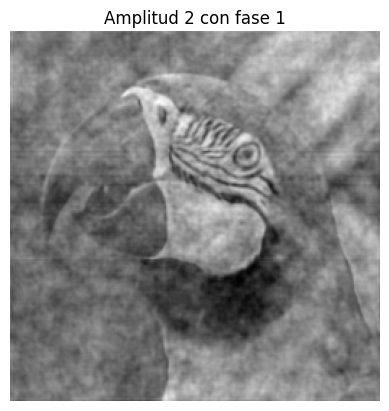

In [2]:
img1 = plt.imread("img1.png")
img2 = plt.imread("img2.png")

fimg1 = np.fft.fft2(img1)
fimg2 = np.fft.fft2(img2)

a_img1 = np.abs(fimg1)
f_img1 = np.angle(fimg1)
a_img2 = np.abs(fimg2)
f_img2 = np.angle(fimg2)

fres1 = a_img1*np.exp(1j * f_img2)
fres2 = a_img2*np.exp(1j * f_img1)

res1 = np.real(np.fft.ifft2(fres1))
res2 = np.real(np.fft.ifft2(fres2))

plt.imshow(img1, cmap='gray')
plt.title("Imagen 1 original")
plt.axis('off')
plt.show()

plt.imshow(img2, cmap='gray')
plt.title("Imagen 2 original")
plt.axis('off')
plt.show()

plt.imshow(res1, cmap='gray')
plt.title("Amplitud 1 con fase 2")
plt.axis('off')
plt.show()
plt.imshow(res2, cmap='gray')
plt.title("Amplitud 2 con fase 1")
plt.axis('off')
plt.show()

## Conclusion
Se puede observar como se puede ver la estructura general de la imagen que dono la fase, cosas como bordes, sin embargo, detalles mas finos se pierden totalmente.

# Ejercicio 2: Eliminacion de degradacion periodica

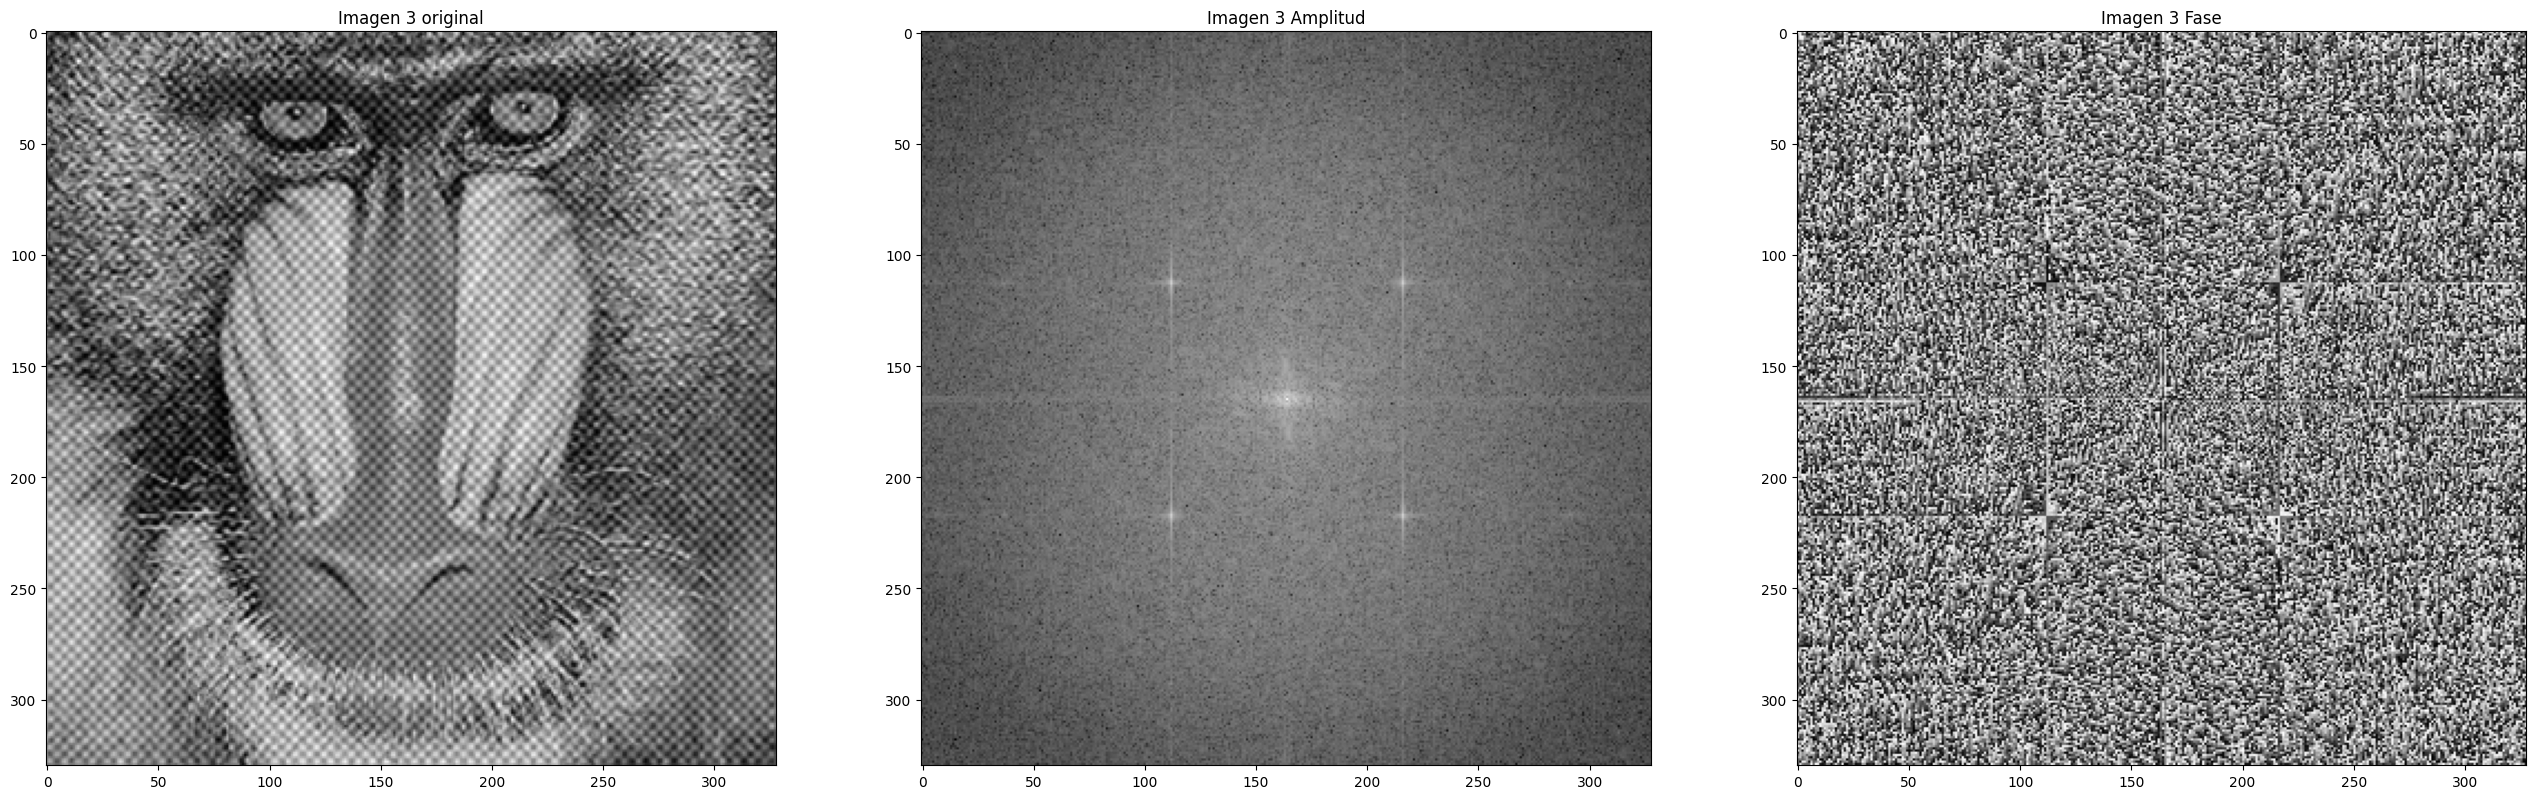

In [3]:
## Importamos la imagen
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
img3 = plt.imread('img3.png')
plt.subplot(131), plt.imshow(img3, cmap='gray'), plt.title("Imagen 3 original")


## La llevamos al espacio de Fourier
fimg3 = np.fft.fft2(img3)

## Se realiza el shift hacia el centro
fimg3c = np.fft.fftshift(fimg3)
## Amplitud
plt.subplot(132), plt.imshow(np.log(np.abs(fimg3c)),'gray'), plt.title("Imagen 3 Amplitud")
## Fase
plt.subplot(133), plt.imshow(np.angle(fimg3c),'gray'), plt.title("Imagen 3 Fase")
plt.show()

In [4]:
## Generamos un filtro
def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def idealFilterLP(D0, imgShape):
    base =  np.zeros(imgShape[:2])
    rows, cols =  imgShape[:2]
    center = (rows/2, cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x), center) < D0:
                base[y,x] = 1.0
    return base

def butterworthLP(D0, imgShape, n):
    base =  np.zeros(imgShape[:2])
    rows, cols =  imgShape[:2]
    center = (rows/2, cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1 / (1+(distance((y,x), center)/D0)**(2*n))
    return base

def gaussianLP(D0, imgShape):
    base =  np.zeros(imgShape[:2])
    rows, cols =  imgShape[:2]
    center = (rows/2, cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = np.exp(((-distance((y,x), center)**2)/(2*(D0**2))))
    return base

In [5]:
## Aplicamos el filtro
LPC50_g = fimg3c * gaussianLP(25, fimg3c.shape)
LPC50_b = fimg3c * butterworthLP(50, fimg3c.shape, 5)
LPC50_i = fimg3c * idealFilterLP(55, fimg3c.shape)
LP50_g = np.fft.ifftshift(LPC50_g)
LP50_b = np.fft.ifftshift(LPC50_b)
LP50_i = np.fft.ifftshift(LPC50_i)
img_LP50_g = np.fft.ifft2(LP50_g)
img_LP50_b = np.fft.ifft2(LP50_b)
img_LP50_i = np.fft.ifft2(LP50_i)

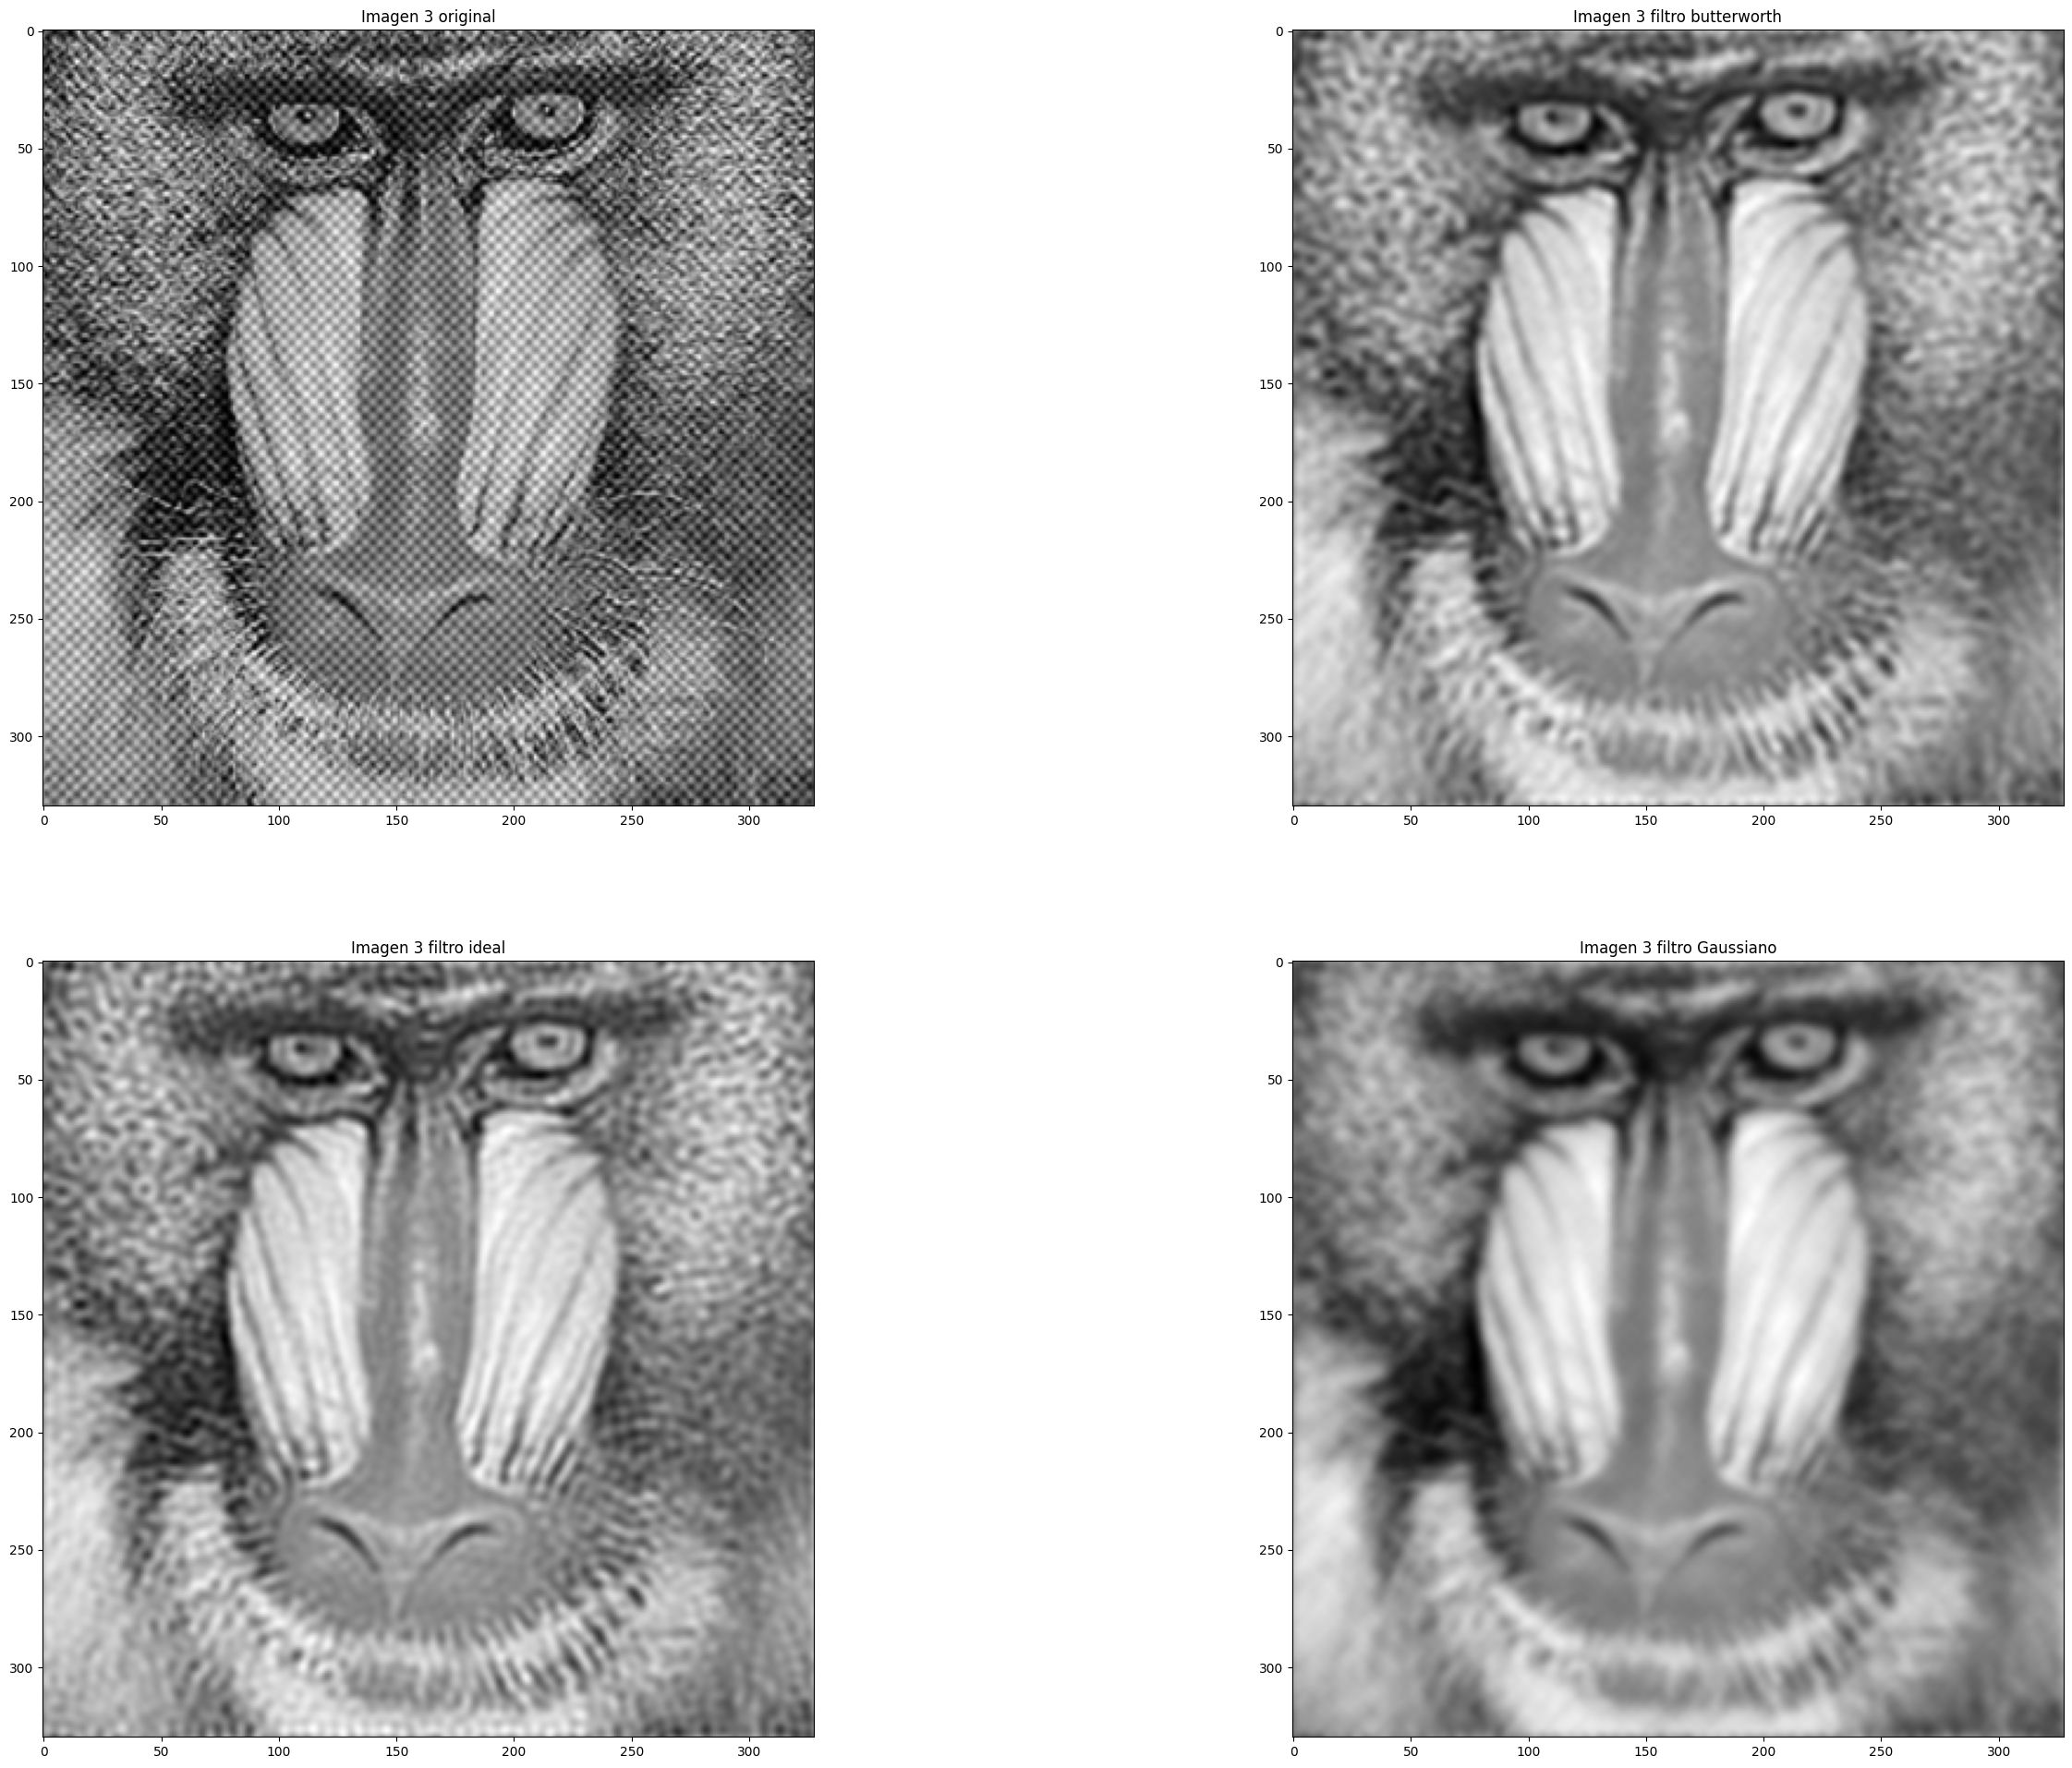

In [6]:
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)

plt.subplot(224)
plt.imshow(np.abs(img_LP50_g), cmap='gray')
plt.title("Imagen 3 filtro Gaussiano")

plt.subplot(222)
plt.imshow(np.abs(img_LP50_b), cmap='gray')
plt.title("Imagen 3 filtro butterworth")

plt.subplot(223)
plt.imshow(np.abs(img_LP50_i), cmap='gray')
plt.title("Imagen 3 filtro ideal")

plt.subplot(221)
plt.imshow(img3, cmap='gray')
plt.title("Imagen 3 original")

plt.show()


# Ejercicio 3: Mejora de imagen

## Encontrar el minimo de la funcion de energia

Bien, entonces el gradiente de E(u) es igual a lo siguiente
$$
    \nabla E(u) = u(x) - u_0(x) - \frac{\gamma}{2} \int_\Omega w(x-y)(u(x) - u(y))dy
$$
Centrandose en el termino de la integral se puede expandir de la siguiente forma
$$
    \int_\Omega w(x-y)(u(x) - u(y))dy = u(x)\int_\Omega w(x-y) - \int_\Omega w(x-y)u(y)dy
$$
El primer termino, al ser $w$ un kernel gaussiano normalizado, la integral sobre el dominio es igual a 1, mientras que en el segundo termino, a parece la definicion de la convolucion entre dos funciones, resultando entonces en lo siguiente
$$
    \nabla E(u) = u - u_0 - \gamma (u - w*u )
$$
donde $*$ es la convolucion.

Ahora bien, si se aplica la transformada de fourier a lo anterior entonces se tendria por las propiedades de este que
$$
    F(\nabla E(u)) = F(u) - F(u_0) - \gamma F(u) + F(w)F(u)
$$
Que al estar encontrando el minimo esta igualado a 0, entonces

$$
    F(u)(1- \gamma - F(w)) = F(u_0)
$$

$$
    F(u) = \frac{F(u_0)}{1 - \gamma - F(w)}
$$


Entonces, en este punto se debe de cuidar que
$$
    1 - \gamma - F(w) \neq 0
$$
Dado que $w$ es un kernel gaussiana normalizado, su transformada de fourier es una funcion que esta entre 0 y 1, por lo tanto, si se garantiza que $\gamma$ tiene el tamanio adecuado, no siendo demasiado grande, la funcion de minimizacion existe y es unica.


In [7]:
def fast_gaussian_convolution(u, sigma):
    # Crear el kernel gaussiano 1D
    gaussian_kernel_1d_1 = gaussian(u.shape[0], sigma)
    gaussian_kernel_1d_2 = gaussian(u.shape[1], sigma)
    
    # Expandir a 2D
    gaussian_kernel_2d = np.outer(gaussian_kernel_1d_1, gaussian_kernel_1d_2)
    gaussian_kernel_2d /= np.sum(gaussian_kernel_2d)  # Normalizar el kernel
    
    # Obtener la cantidad de canales de la imagen de entrada
    num_channels = u.shape[2]

    # Expandir a 3D para cada canal de color
    gaussian_kernel_3d = np.stack([gaussian_kernel_2d] * num_channels, axis=2)

    # Aplicar la convolución para cada canal utilizando convolve
    convolucionada = np.zeros_like(u)
    for channel in range(num_channels):
        convolucionada[:, :, channel] = convolve(u[:, :, channel], gaussian_kernel_2d, mode='same')
    
    return convolucionada

In [8]:
def grad_desc_img_enhance(img, alpha, sigma1,sigma2, kmax, epsilon, lm1, lm2):
    Lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    L0 = copy.deepcopy(np.asarray([Lab[:,:,0]]))
    L0 = np.transpose(L0, (1, 2, 0))
    O01 = copy.deepcopy(np.asarray([Lab[:,:,1]]))
    O01 = np.transpose(O01, (1, 2, 0))
    print(O01.shape)
    O02 = copy.deepcopy(np.asarray([Lab[:,:,2]]))
    O02 = np.transpose(O02, (1, 2, 0))
    print(O02.shape)
    L = copy.deepcopy(np.asarray([Lab[:,:,0]]))
    L = np.transpose(L, (1, 2, 0))
    O1 = copy.deepcopy(np.asarray([Lab[:,:,1]]))
    O1 = np.transpose(O1, (1, 2, 0))
    O2 = copy.deepcopy(np.asarray([Lab[:,:,2]]))
    O2 = np.transpose(O2, (1, 2, 0))
    ##Luminosidad
    k=0
    while k<kmax :
        if k == 5:
            print(np.mean((L - Lp)**2))
        if k>0 and np.mean((L - Lp)**2) < epsilon:
            break;
        conv = fast_gaussian_convolution(L, sigma1)
        Lp = copy.deepcopy(L)
        L = L - alpha*((L-L0) - (lm1*(L - conv)))
        k+=1
    ##Color
    print(np.mean((L - Lp)**2))
    print(k)
    k=0
    while k<kmax :
        if k == 5:
            print(np.mean((O1 - O1p)**2))
        if k>0 and np.mean((O1 - O1p)**2) < epsilon:
            break;
        conv = fast_gaussian_convolution(O1, sigma2)
        O1p = copy.deepcopy(O1)
        O1 = O1 - alpha*((O1-O01) - (lm2*(O1 - conv)))
        k+=1
    print(np.mean((O1 - O1p)**2))
    print(k)
    k=0
    while k<kmax :
        if k == 5:
            print(np.mean((O2 - O2p)**2))
        if k>0 and np.mean((O2 - O2p)**2) < epsilon:
            break;
        conv = fast_gaussian_convolution(O2, sigma2)
        O2p = copy.deepcopy(O2)
        O2 = O2 - alpha*((O2-O02) - (lm2*(O2 - conv)))
        k+=1
    print(np.mean((O2 - O2p)**2))
    print(k)
    return cv2.merge((L,O1, O2))

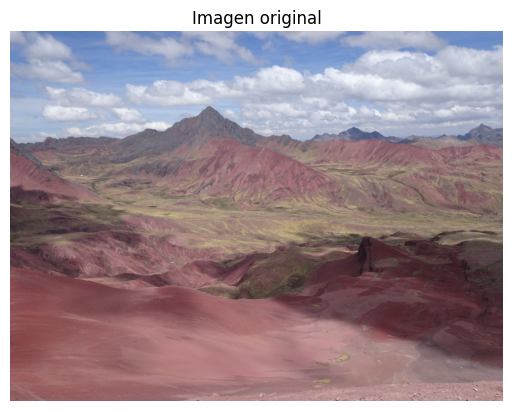

In [9]:
img = cv2.imread("img4.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.title('Imagen original')
plt.show()

In [10]:
alpha = 0.1
epsilon = 0.0001
kmax = 15000
sigma1 = 5
sigma2 = 300
lm1 = 0.25
lm2 = 0.1

In [11]:
img_res = grad_desc_img_enhance(img, alpha, sigma1,sigma2, kmax, epsilon, lm1, lm2)

(768, 1024, 1)
(768, 1024, 1)
0.1500079988863053
8.952348786763413e-05
49
0.14552288362238358
8.234125727731377e-05
43
0.11586091572206036
9.41815605745722e-05
41


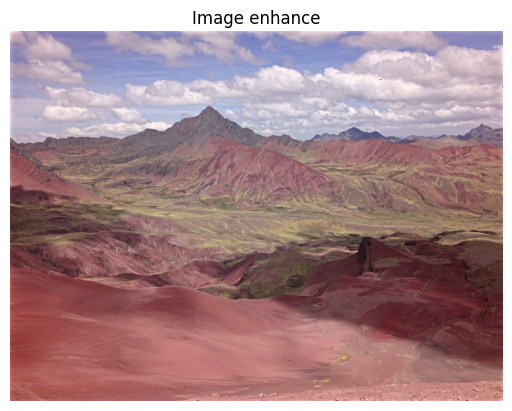

In [12]:
img_res_int = img_res.astype(np.uint8)
img_res_rgb = cv2.cvtColor(img_res_int, cv2.COLOR_Lab2RGB)
plt.imshow(img_res_rgb)
plt.axis('off')
plt.title("Image enhance")
plt.show()

In [13]:
img_res_bgr = cv2.cvtColor(img_res_rgb, cv2.COLOR_RGB2BGR)

In [14]:
cv2.imwrite('img4m.png', img_res_bgr)

True

# Ejercicio 4: Descriptores de Fourier

## Invarianza de los descriptores de Fourier

### Invarianza ante corrimientos

Una funcion periodica se puede escribir a traves de las series de Fourier tal que
$$
    f(x) = \sum_{n=0}^\infty c_n e^{2i \pi nx}
$$
con $|c_k| = |c_{-k}|$
$$
    c_k = \int_0^1 f(x) e^{-2i \pi kx}dx
$$

Para el caso de la traslacion de una funcion es decir $g(x) = f(x-a)$, se tiene que los coeficientes serian
$$
    c_k^* = \int_0^1 g(x) e^{-2i \pi kx}dx
$$
haciendo un cambio de variable de x = t+a, entonces

$$
    c_k^* = \int_0^1 g(x+a) e^{-2i \pi k(x+a)}dx =  e^{-2i \pi ka} \int_0^1 g(x+a) e^{-2i \pi kx}dx
$$
sustituyendo $g(x) = f(x-a)$, entonces
$$
    c_k^* = e^{-2i \pi ka} \int_0^1 f(x) e^{-2i \pi kx}dx = e^{-2i \pi ka} \left( \int_0^1 f(x) e^{-2i \pi kx}dx \right)
$$

$$
    c_k^* = e^{-2 \pi ka} c_k
$$

Dado que los descriptores de Fourier se relacionan con la magnitud de los coeficientes de Fourier, el termino extra que aparece unicamente esta relacionado con la fase, por lo tanto $|c_k^*| = |c_k|$ confirmando la invarianza.

### Invarianza ante rotaciones

Si ahora proponemos la siguiente transformacion $g(x) = f(x)e^{-i \theta}  $, al obtener los coeficientes de Fourier se tiene que
$$
    c_k^* = \int_0^1 g(x) e^{-2i \pi k x}dx
$$

Sustituyendo la funcion $g(x) = f(x)e^{-i \theta}$ entonces
$$
    c_k^* = \int_0^1 f(x)e^{-i\theta} e^{-2i \pi k x}dx =e^{-i\theta} \int_0^1 f(x) e^{-2i \pi k x}dx
$$
$$
    c_k^* = e^{-i\theta} c_k
$$
Nuevamente, dado que los descriptores se relacionan a la magnitud de los coeficientes y no a la fase, que es el termino que afecta el factor que aparece, se confirma la invarianza

### Invarianza ante escalas
Se realiza un escalado tal que $g(x) = hf(x)$, entonces los coeficientes de fourier son

$$
    c_k^* = \int_0^1 g(x) e^{-2i \pi k x}dx
$$

Sustituyendo la funcion se tiene que
$$
    c_k^* = \int_0^1 hf(x) e^{-2i \pi k x}dx = h \int_0^1 f(x) e^{-2i \pi k x}dx 
$$
$$
    c_k^* = h c_k
$$

La definicion de los descriptores es la siguiente
$$
    d_n = \frac{|c_n|}{\sum_{m>0}|c_m|}, \hspace{8mm} n>0
$$
entonces los descriptores para g serian
$$
    d_n^* = \frac{|c_n^*|}{\sum_{m>0}|c_m^*|}, \hspace{8mm} n>0
$$
sustituyendo que 
$
    c_k^* = h c_k
$ entonces 
$$
    d_n^* = \frac{|h||c_n|}{\sum_{m>0}|h||c_m|} = \frac{|h||c_n|}{|h| \sum_{m>0}|c_m|}, \hspace{8mm} n>0
$$
por lo tanto $d_n^* = d_n$, lo que los mantiene invariantes

### Invarianza ante traslaciones
Ahora proponemos $g(x) = f(x) +b$, entonces los coeficientes de Fourier se proponen como
$$
    c_k^* = \int_0^1 g(x) e^{-2i \pi k x}dx
$$

Para el caso particular de $n=0$ se tiene que $c_0 = 0$, esto por el heccho de que las funciones $f$ se establecen como curvas cerradas, entonces, veamos que sucede para el coeficiente de g(x)
$$
    c_0^* = \int_0^1 g(x)dx = \int_0^1 f(x) dx + \int_0^1 b dx
$$
$$
    c_0^* = c_0 + b
$$
$$
    c_0^* = b
$$
Sin embargo, como la traslacion no afecta que la curva se mantenga cerrada, eso significa que deberia de ser 0, por lo tanto, esto asegura la invarianza ante traslaciones.

## Implementacion de funcion para obtener los descriptores de Fourier para una curva

In [15]:
def fourier_des(u):
    x = u[:, 0]
    y = u[:, 1]
    cx = np.fft.fft(x)
    cy = np.fft.fft(y)
    mx = np.abs(cx)
    my = np.abs(cy)
    mx[0] = my[0] = 0.0
    dnx = mx / np.sum(mx)
    dny = my / np.sum(my)
    dn = np.concatenate((dnx,dny))
    return dn    

In [16]:
db = np.load('shapes.npy')
def graficar_curva(curva, title):
    """
    Grafica una curva 2D.
    
    Argumentos:
    curva -- Arreglo NumPy con forma (n_puntos, 2) que contiene la curva 2D.
    """
    x = curva[:, 0]
    y = curva[:, 1]
    
    plt.figure()
    plt.plot(x, y)
    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")
    plt.title(title)
    plt.grid(True)
    plt.show()



In [17]:
descriptors = np.zeros((25,402))
for i in range(db.shape[0]):
    descriptors[i,:] = fourier_des(db[i])
descriptors.shape

(25, 402)

In [18]:
from sklearn.cluster import KMeans

In [19]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(descriptors)
y = kmeans.predict(descriptors)

C:\Users\chiko\.conda\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\chiko\.conda\envs\NLP\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\chiko\.conda\envs\NLP\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
C:\Users\chiko\.conda\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

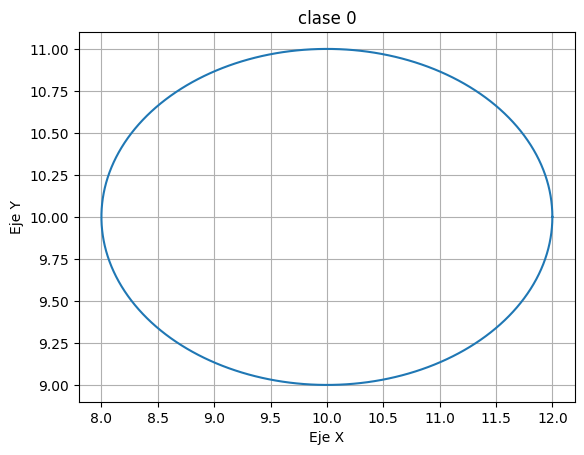

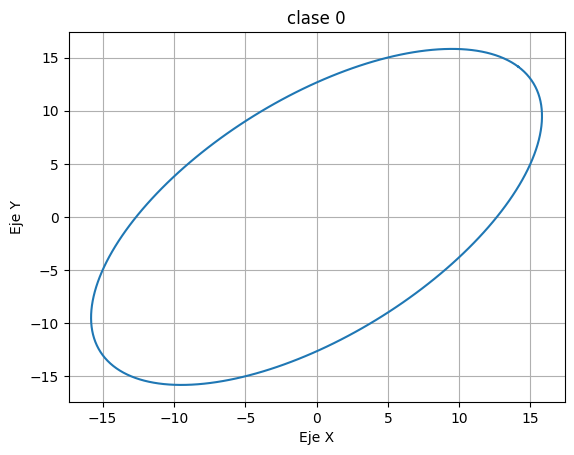

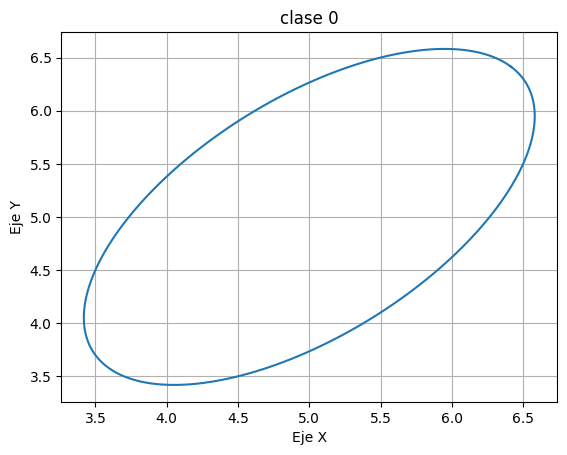

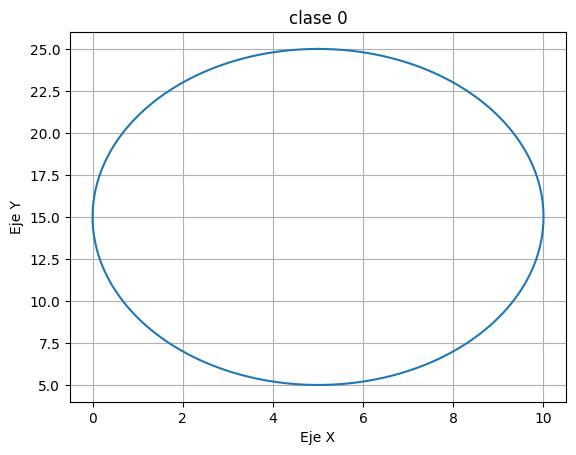

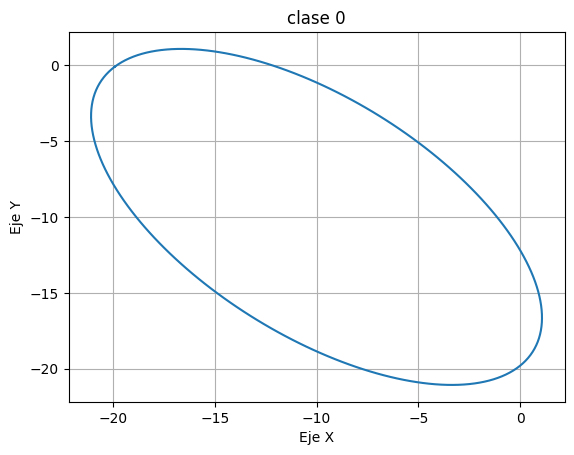

5 5 5 5 5


In [20]:
j0 = j1 = j2 = j3 = j4 = 0
for i in range(len(db)):
    if y[i] == 0:
        graficar_curva(db[i], 'clase 0')
        j0 += 1
    if y[i] == 1:
        j1 += 1
    if y[i] == 2:
        j2 += 1
    if y[i] == 3:
        j3 += 1
    if y[i] == 4:
        j4 += 1
print(j0, j1, j2, j3, j4)

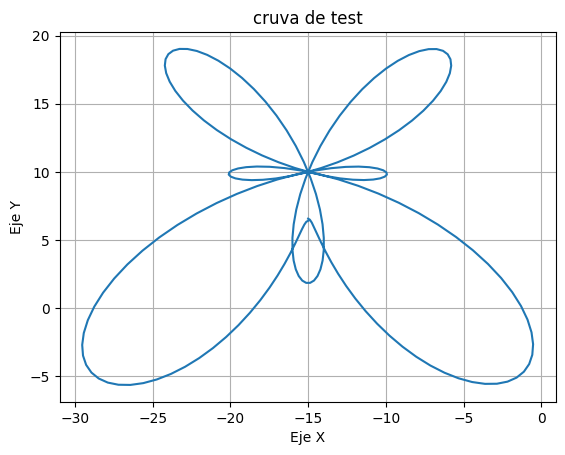

In [21]:
dbt = np.load('new_shape.npy')
graficar_curva(dbt, 'cruva de test')

La imagen de prueba pertenece a la clase  3
Las otras imagenes de la clase 3  son


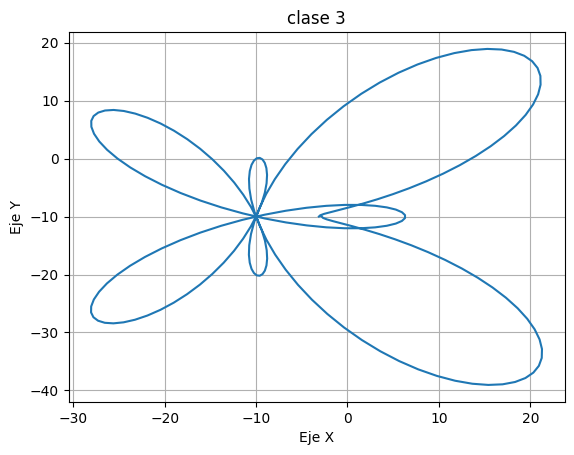

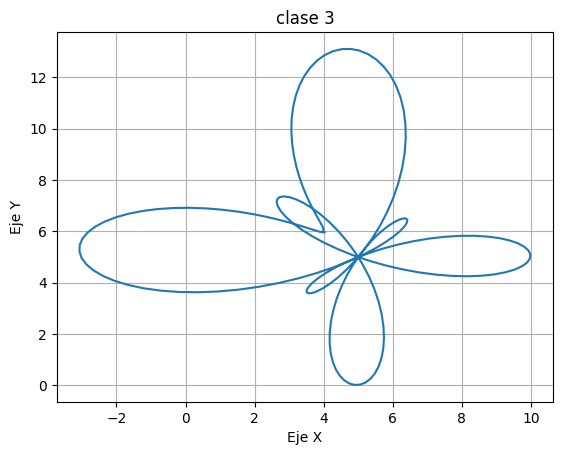

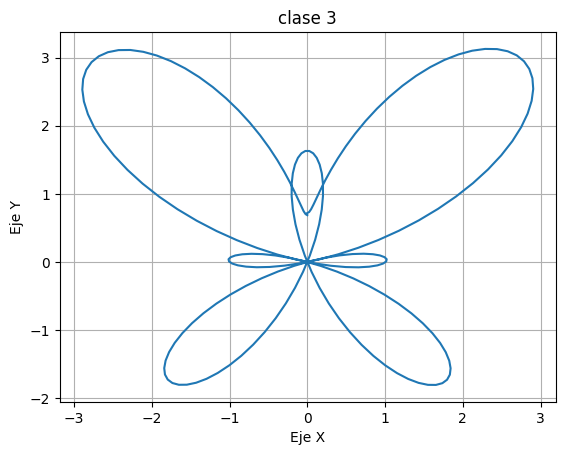

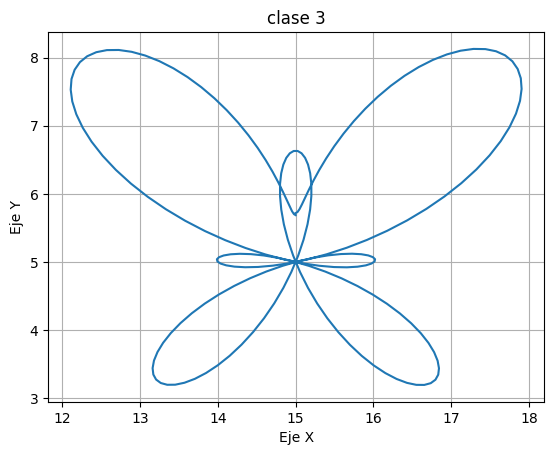

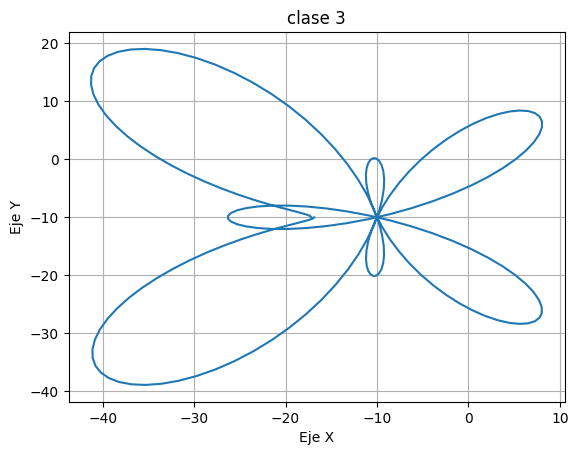

In [24]:
pred = fourier_des(dbt)
yt = kmeans.predict([pred])
print("La imagen de prueba pertenece a la clase ", yt[0])
print('Las otras imagenes de la clase', yt[0], ' son')
for i in range(len(db)):
    if y[i] == yt[0]:
        graficar_curva(db[i], 'clase '+ str(yt[0]))